In [211]:
import os
import numpy as np
import random
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

Put a lot of images (RGB) in the folders dataset/train & dataset/train .  
The training labels will be the images in dataset/train, and the training inputs will those same images but with noise.  
Don't worry if you put some grayscale images by mistake because I've done some error handling for that.

In [212]:
def random_float(low, high):
    return random.random()*(high-low) + low

## Add Noise

In [213]:
def add_noise(image):
    row,col,ch= image.shape
    mean = 0
    var = random_float(0.01,0.1) # a random float between 0.01 & 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy

## Train Generator Function

In [214]:
train_path = 'dataset/train/'
def train():
    for file in os.listdir(train_path):
        img = Image.open(train_path+file)
        # Resize
        img = img.resize((512,360), Image.ANTIALIAS)
        # Convert to array then Normalise pixel values
        img = np.array(img)/255.0
        # Accept RGB images only
        if len(img.shape)==3:
            if img.shape[2]==3:
                noisy = add_noise(img)
                img = np.reshape(img,(1,360,512,3))
                noisy = np.reshape(noisy,(1,360,512,3))
                yield noisy,img

## Test Generator Function

In [215]:
test_path = 'dataset/test/'
def test():
    for file in os.listdir(test_path):
        img = Image.open(test_path+file)
        # Resize
        img = img.resize((512,360), Image.ANTIALIAS)
        # Convert to array then Normalise pixel values
        img = np.array(img)/255.0
        # Accept RGB images only
        if len(img.shape)==3:
            if img.shape[2]==3:
                noisy = add_noise(img)
                img = np.reshape(img,(1,360,512,3))
                noisy = np.reshape(noisy,(1,360,512,3))
                yield noisy,img

In [216]:
total_train = len(os.listdir(train_path))
total_test = len(os.listdir(test_path))
print('Total Train Samples:',total_train)
print('Total Test Samples:',total_test)

Total Train Samples: 4122
Total Test Samples: 1015


## Autoencoder Model

In [53]:
image = Input(shape=(360,512,3))

# Encoder
l1 = Conv2D(64, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(image)     
l2 = Conv2D(64, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l1)

l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l6)

#Decoder
l8 = UpSampling2D()(l7)
l9 = Conv2D(128, (3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(128, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l9)

l11 = add([l5,l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(64, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l13)

l15 = add([l14,l2])

decoded = Conv2D(3, (3,3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10))(l15)
model = Model(image, decoded)

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 360, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 360, 512, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 360, 512, 64) 36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 180, 256, 64) 0           conv2d_11[0][0]                  
____________________________________________________________________________________________

## Fit Model

In [241]:
checkpoint = ModelCheckpoint('De-noise.h5')
model.fit(train(), steps_per_epoch=total_train,
          epochs=1, callbacks=[checkpoint])

## Load Pre-trained Model

In [198]:
model = load_model('De-noise-Pre-trained.h5')

## Evaluate

In [239]:
_,acc = model.evaluate(test(),steps=total_test)
print('Accuracy:{}'.format(acc))

## Predict from Test dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


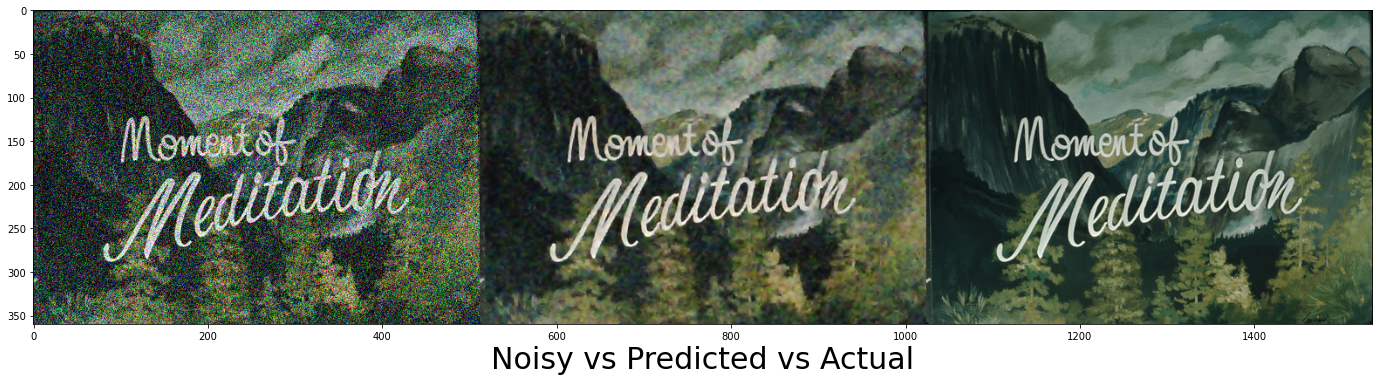

In [238]:
INDEX = 8
file = os.listdir(test_path)[INDEX] # Image path
img = Image.open(test_path+file) # Load Image
img = img.resize((512,360), Image.ANTIALIAS) # Resize
img = np.array(img)/255.0 # Normalise pixel values
noisy = add_noise(img) # add noise
# Assuming that some grayscale images were put in the folder by mistake
# So added some Error Handling
try:
    img = np.reshape(img,(1,360,512,3))
    noisy = np.reshape(noisy,(1,360,512,3))
    predicted = model.predict(noisy) # Predict
    # Merge images
    image = np.hstack((noisy[0],predicted[0],img[0]))
    # Plot
    plt.subplots(figsize=(24, 6))
    plt.imshow(image)
    plt.xlabel('Noisy vs Predicted vs Actual',fontsize=30)
except:
    raise ValueError('INDEX={} is a grayscale image, which is invalid, select another one'.format(INDEX))